# HRV EDA

In [2]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os

utils.default_plot_format()
utils.pd_display_settings(3)

Predefine where data is and where the plotly images will be saved

In [3]:
#data_path = r'processed_data\5min_nabian_2025_03_03.pkl'
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
#data_path = "processed_data/manual_10min_2025_03_03.pkl"
#data_path = r'processed_data\raw_metrics\optimized_20min_Nabian.pkl'
title_addon = " (10 min segments)"

In [4]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


# Median only comparison:
We first derive median of each metric and put them into a single df

In [5]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

median_melted.tail(3)

,id,DPN,metric,value
517,38,True,D2,-2.16
518,39,True,D2,-3.26
519,40,True,D2,-2.75


In [6]:
from general_utils import CorrectedMultivariableTest as CMT

importlib.reload(CMT)


test = CMT.CorrectedMultivariableTest(
    data=median_melted, 
    group_col='metric',
    value_col='value',
    cat_col='DPN',
    cat_val_1=False,
    cat_val_2=True
)


result = test.perform_ManWhitney_U_tests()
result.sort_values('p_value', inplace=True)
display(result)
result.reset_index(inplace=True, drop=False)

,U_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
HF Power,80,0.00709,True,20,0.05,True
LF Power,76,0.0207,True,19,0.0475,True
SDRR,74,0.0322,True,17,0.0425,True
SD2,74,0.0322,True,18,0.045,True
S,73,0.0395,True,16,0.04,True
SD1,71,0.0577,False,15,0.0375,False
RMSSD,71,0.0577,False,14,0.035,False
Mean HR (bpm),18,0.0689,False,13,0.0325,False
pNN50 (%),69,0.0815,False,12,0.03,False


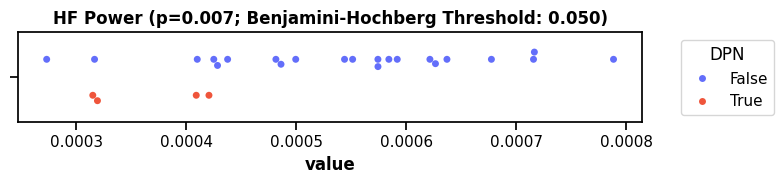

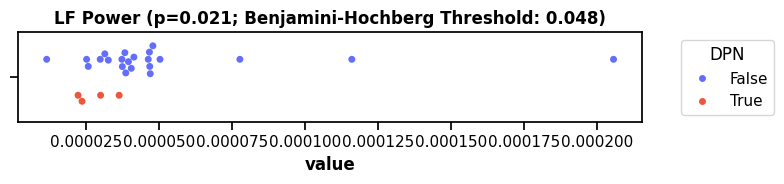

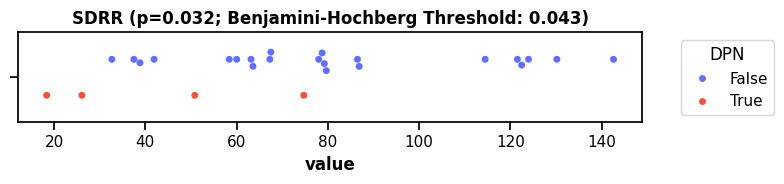

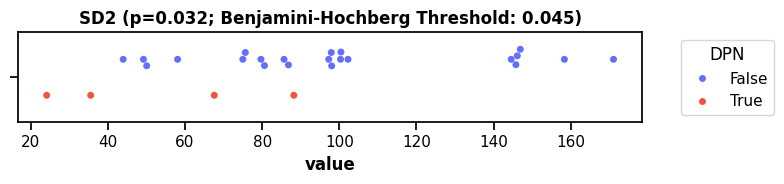

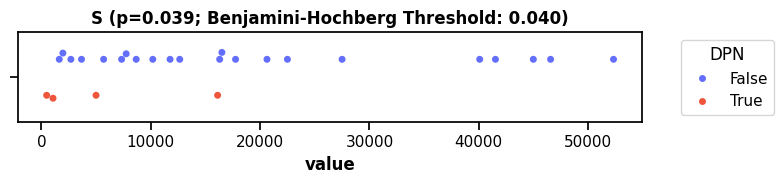

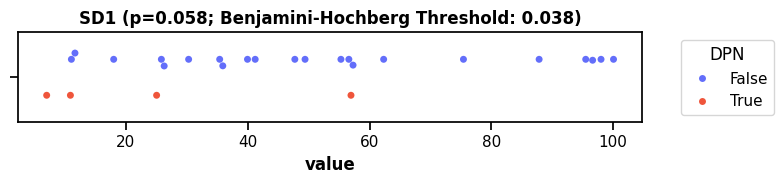

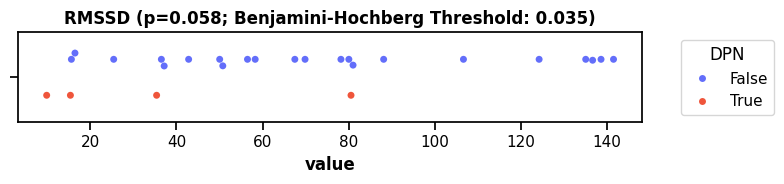

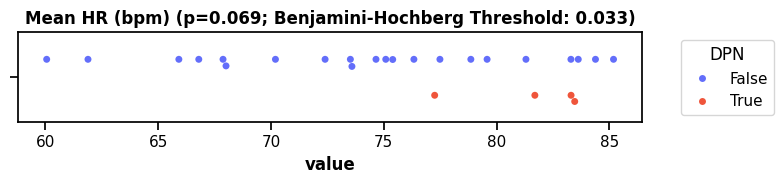

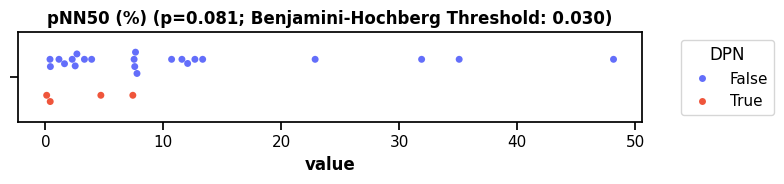

In [7]:
for i, row in result.iterrows():
    if row['p_value']<0.1:
        title = f"{row['metric']} (p={row['p_value']:.3f}; Benjamini-Hochberg Threshold: {row['BH_threshold']:.3f})"
        plt.figure(figsize=(8, 2))
        plt.title(title)
        sns.swarmplot(
            data=median_melted[median_melted['metric'] == row['metric']],  
            hue = 'DPN',
            x='value',
            dodge=True
        )
        # Move legend outside the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='DPN')
        plt.tight_layout()

# MEDIAN ABSOLUTE DEVIATION

In [8]:
def normalize_melt(df):
    df = df[df.metric!='D2']
    for metric in df["metric"].unique():
        mask = df["metric"]==metric
        values = df[df["metric"]==metric]["value"]
        df.loc[mask, "value"] = values / values.max()

    return df


def plot_normalized(df, title=None, figsize=(8, 15)):
    plt.figure(figsize=figsize)
    sns.swarmplot(data=df, y='metric', x='value', hue = 'DPN', size=4)
    plt.title(title)
    plt.show()

In [9]:
# Mad values
import scipy.stats as stats
import numpy as np


mad=data.groupby(["id", 'DPN'])[indicator_columns].agg(stats.median_abs_deviation)
mad_melt = mad.reset_index().melt(id_vars=["id", 'DPN'], value_vars=indicator_columns, var_name='metric', value_name = 'value')
display(mad_melt)

,id,DPN,metric,value
0,0,False,SDRR,20.41
1,3,False,SDRR,25.05
2,4,False,SDRR,31.20
3,5,False,SDRR,16.02
4,7,False,SDRR,30.90
...,...,...,...,...
515,35,False,D2,NaN
516,37,True,D2,NaN
517,38,True,D2,NaN
518,39,True,D2,NaN


In [10]:
test = CMT.CorrectedMultivariableTest(
    data=mad_melt, 
    group_col='metric',
    value_col='value',
    cat_col='DPN',
    cat_val_1=False,
    cat_val_2=True
)


result = test.perform_ManWhitney_U_tests()
result.sort_values('p_value', inplace=True)
display(result)
result.reset_index(inplace=True, drop=False)

,U_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SampEn,14,0.0322,True,19,0.0475,True
DFA α1,17,0.0577,False,18,0.045,False
ApEn,18,0.0689,False,17,0.0425,False
LF Peak Frequency,19,0.0815,False,16,0.04,False
VLF Peak Frequency,20,0.0959,False,14,0.035,False
S,68,0.0959,False,15,0.0375,False
DFA α2,23,0.15,False,13,0.0325,False
SD2,65,0.15,False,12,0.03,False
SDRR,64,0.17,False,11,0.0275,False


In [11]:
#to_plot = [x for x in time_metrics if x != "S"]
#figsize = (8, 5)
#plot_normalized(normalize_melt(mad_melt[mad_melt["metric"].isin(to_plot )]), "Normalized Median Absolute Deviation Distribution", figsize)
#plot_normalized(normalize_melt(median_melted[median_melted["metric"].isin(to_plot )]), "Normalized Median Distribution", figsize)

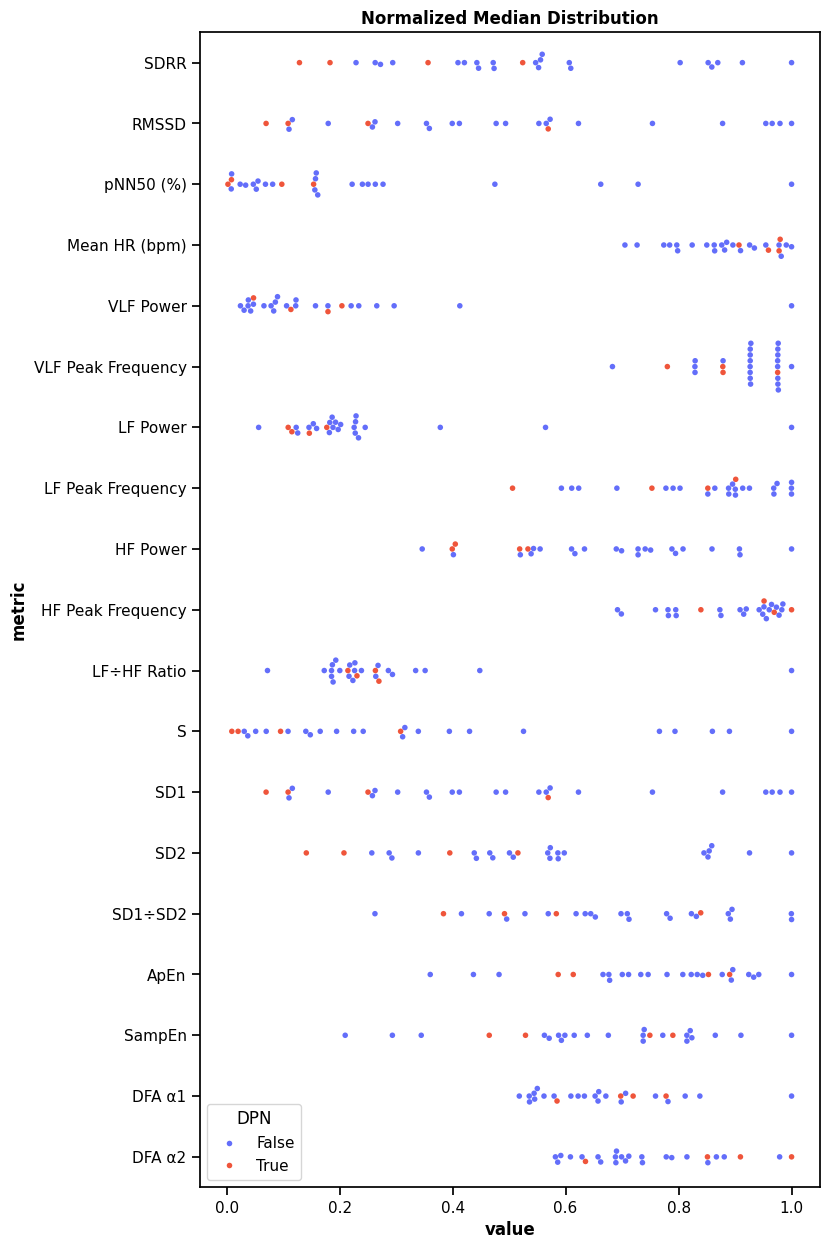

In [12]:
plot_normalized(normalize_melt(median_melted), "Normalized Median Distribution")

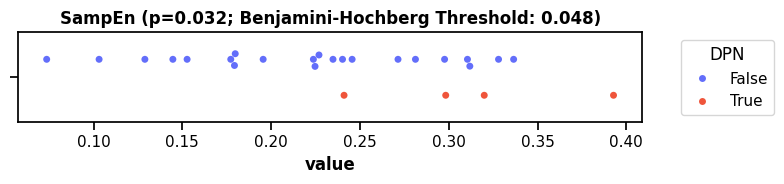

In [13]:
for i, row in result.iterrows():
    if  row["metric"]=="SampEn":
        title = f"{row['metric']} (p={row['p_value']:.3f}; Benjamini-Hochberg Threshold: {row['BH_threshold']:.3f})"
        plt.figure(figsize=(8, 2))
        plt.title(title)
        sns.swarmplot(
            data=mad_melt[mad_melt['metric'] == row['metric']],  
            hue = 'DPN',
            x='value',
            dodge=True
        )
        # Move legend outside the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='DPN')
        plt.tight_layout()

# Permutations test

In [14]:
stats.permutation_test

<function scipy.stats._resampling.permutation_test(data, statistic, *, permutation_type='independent', vectorized=None, n_resamples=9999, batch=None, alternative='two-sided', axis=0, rng=None)>

In [15]:
importlib.reload(CMT)
import numpy as np
from copy import deepcopy

test = CMT.CorrectedMultivariableTest(
    data=median_melted, 
    group_col='metric',
    value_col='value',
    cat_col='DPN',
    cat_val_1=False,
    cat_val_2=True
)

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = test.permutation_test(statistic, n_permutations=1000)

result.sort_values('p_value', inplace=True)
to_print = deepcopy(result)
to_print.drop(columns=["distribution"], inplace=True)
display(to_print)


,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
HF Power,0.000178,0.012,True,20,0.05,True
SD2,45.85,0.026,True,19,0.0475,True
SDRR,38.18,0.03,True,18,0.045,True
Mean HR (bpm),-7.09,0.0519,False,17,0.0425,False
RMSSD,39.11,0.0519,False,16,0.04,False
LF Power,2.25e-05,0.0599,False,15,0.0375,False
SD1,27.65,0.0759,False,14,0.035,False
S,13459,0.0839,False,13,0.0325,False
DFA α2,-0.14,0.0859,False,12,0.03,False


,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
HF Power,0.000178,0.012,True,20,0.05,True


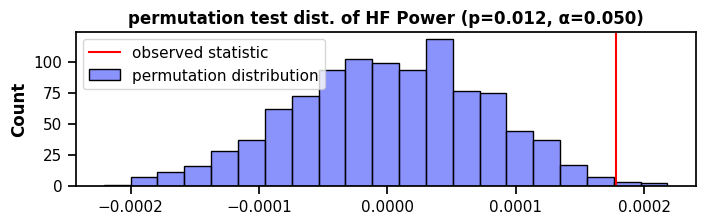

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SD2,45.85,0.026,True,19,0.0475,True


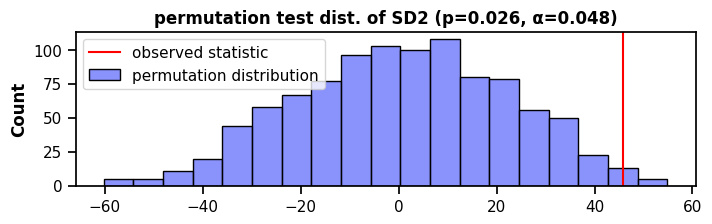

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SDRR,38.18,0.03,True,18,0.045,True


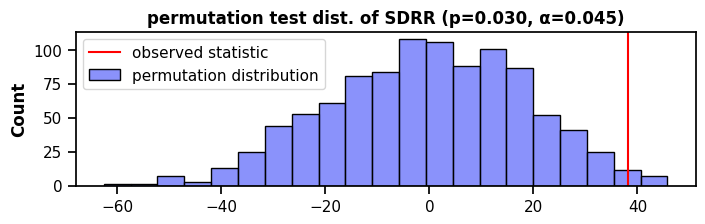

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
Mean HR (bpm),-7.09,0.0519,False,17,0.0425,False


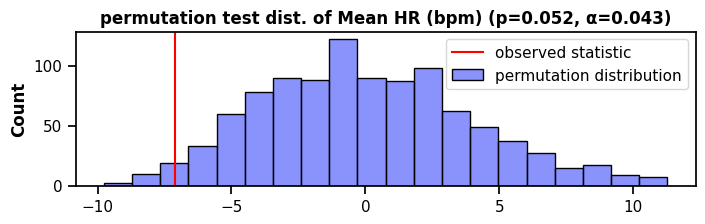

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
RMSSD,39.11,0.0519,False,16,0.04,False


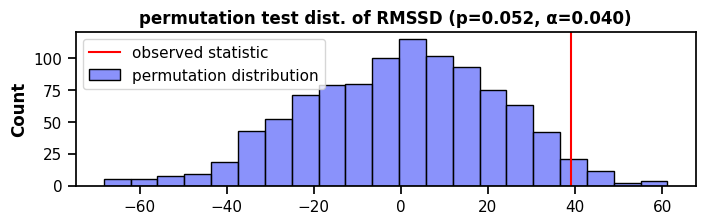

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
LF Power,2.25e-05,0.0599,False,15,0.0375,False


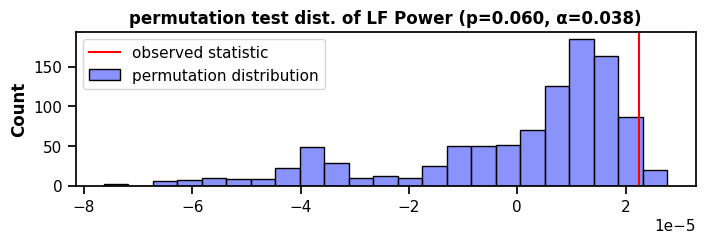

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SD1,27.65,0.0759,False,14,0.035,False


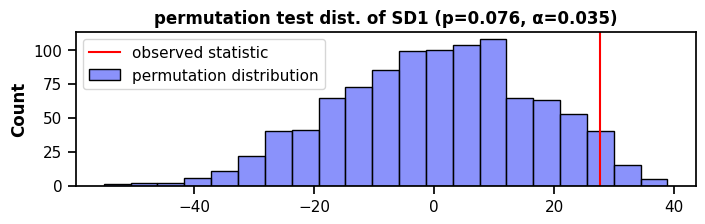

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
S,13459,0.0839,False,13,0.0325,False


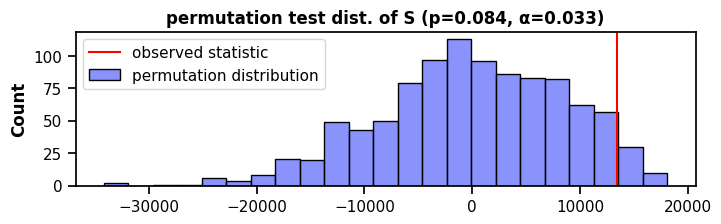

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
DFA α2,-0.14,0.0859,False,12,0.03,False


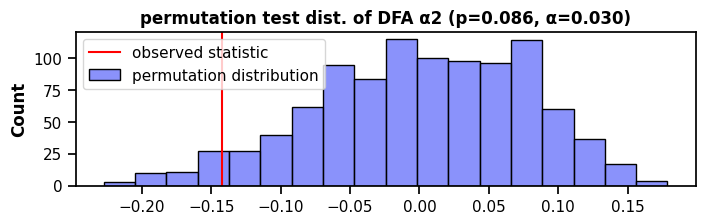

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
pNN50 (%),8.07,0.12,False,11,0.0275,False


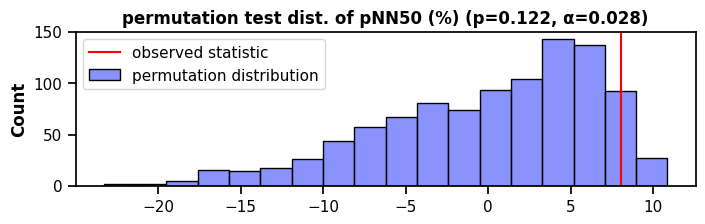

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
LF Peak Frequency,0.0139,0.20,False,10,0.025,False


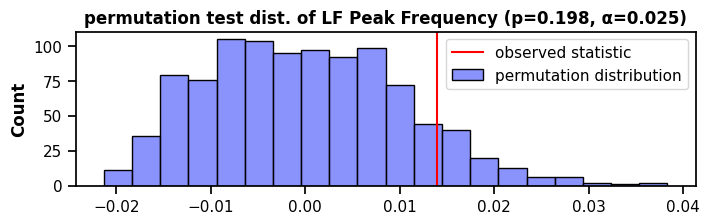

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SD1÷SD2,0.0897,0.25,False,9,0.0225,False


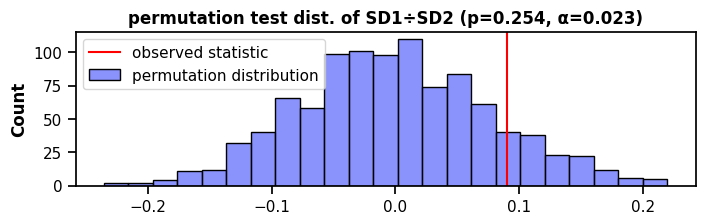

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
D2,0.67,0.26,False,8,0.02,False


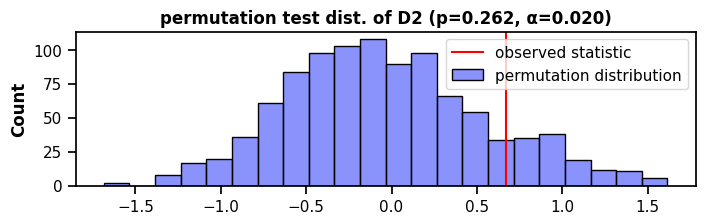

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
VLF Peak Frequency,0.00148,0.29,False,7,0.0175,False


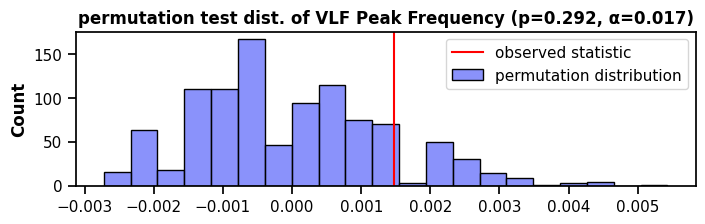

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
HF Peak Frequency,-0.0211,0.31,False,6,0.015,False


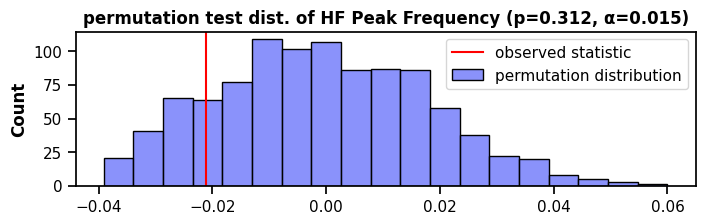

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
DFA α1,-0.0518,0.49,False,5,0.0125,False


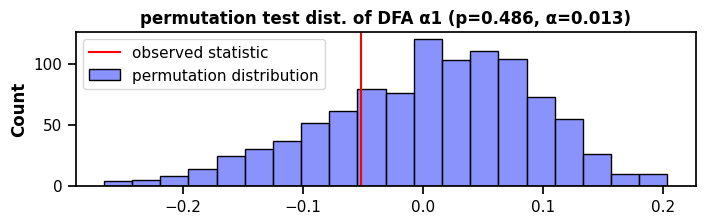

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SampEn,0.0494,0.71,False,4,0.01,False


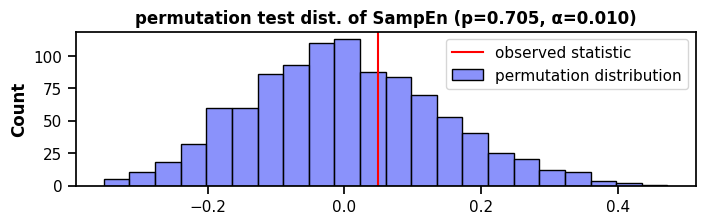

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
ApEn,0.0312,0.76,False,3,0.0075,False


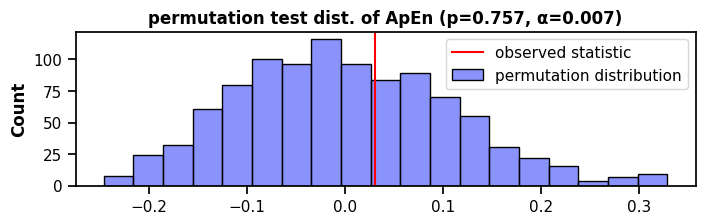

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
LF÷HF Ratio,0.00943,0.97,False,2,0.005,False


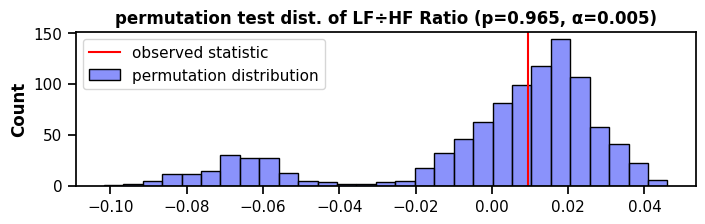

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
VLF Power,9.53e-07,0.98,False,1,0.0025,False


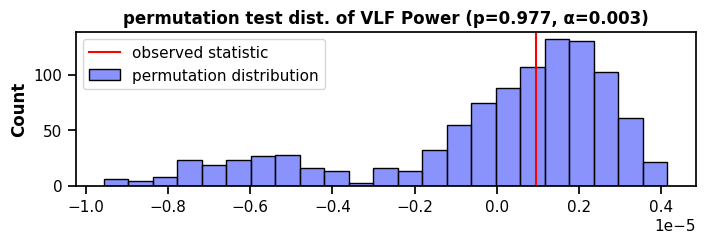

In [16]:
result.tail(3)
for metric in result.index:
    display(to_print[to_print.index == metric])
    plt.figure(figsize=(8, 2))
    sns.histplot(data=result.loc[metric, "distribution"])
    title = f"permutation test dist. of {metric} (p={result.loc[metric, 'p_value']:.3f}, α={result.loc[metric, 'BH_threshold']:.3f})"
    plt.title(title)
    plt.axvline(result.loc[metric, "perm_statistic"], color='red')
    plt.legend(["observed statistic", "permutation distribution"])
    plt.show()

In [17]:
#plot_normalized(normalize_melt(median_melted), "Normalized Median Distribution")

## Odds ratio

In [18]:
median = data.groupby(['id', 'DPN'])[indicator_columns].median()
median = median.reset_index()
median.tail(2)

,id,DPN,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),VLF Power,VLF Peak Frequency,LF Power,LF Peak Frequency,...,LF÷HF Ratio,S,SD1,SD2,SD1÷SD2,ApEn,SampEn,DFA α1,DFA α2,D2
24,39,True,26.09,15.39,0.41,83.30,5.73e-06,0.03,2.24e-05,0.0684,...,0.0741,1059,10.88,35.53,0.37,0.76,0.72,1.00,1.04,-3.26
25,40,True,50.84,35.41,7.41,81.70,3.19e-06,0.03,3.01e-05,0.12,...,0.093,4993,25.04,67.59,0.43,1.06,1.03,0.97,0.97,-2.75


In [19]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### KDE derrival
Weight the KDE by number of units

In [20]:
def compute_kde_for_metric(data, metric, weight_data = False):
    # Separate the data based on the 'DPN' column
    control_data = data[data['DPN'] == False][metric]
    dpn_data = data[data['DPN'] == True][metric]

    # Compute the kernel density estimate for each group
    control_kde = stats.gaussian_kde(control_data) 
    dpn_kde = stats.gaussian_kde(dpn_data)  

    x_values = np.linspace(min(data[metric]), max(data[metric]), 100)

    kde_df = pd.DataFrame({
        'x_values': x_values,
        'control_kde': control_kde(x_values),
        'dpn_kde': dpn_kde(x_values),
    })
    if weight_data:
        kde_df["control_kde"] = kde_df["control_kde"] * sum(data['DPN'] == False)/len(data['DPN'])
        kde_df["dpn_kde"] = kde_df["dpn_kde"] * sum(data['DPN'] == True)/len(data['DPN'])

    kde_df["dpn_chance"] = kde_df["dpn_kde"] / (kde_df["dpn_kde"] + kde_df["control_kde"])

    return kde_df

# Example usage
metric = 'SDRR'
kde_df = compute_kde_for_metric(median, metric)
display(kde_df)

,x_values,control_kde,dpn_kde,dpn_chance
0,18.38,0.00252,0.0112,0.82
1,19.63,0.00274,0.0115,0.81
2,20.89,0.00298,0.0117,0.80
3,22.14,0.00322,0.0119,0.79
4,23.40,0.00347,0.0121,0.78
...,...,...,...,...
95,137.58,0.00458,2.68e-05,0.00582
96,138.83,0.00439,2.17e-05,0.00492
97,140.09,0.00419,1.75e-05,0.00415
98,141.34,0.00398,1.4e-05,0.0035


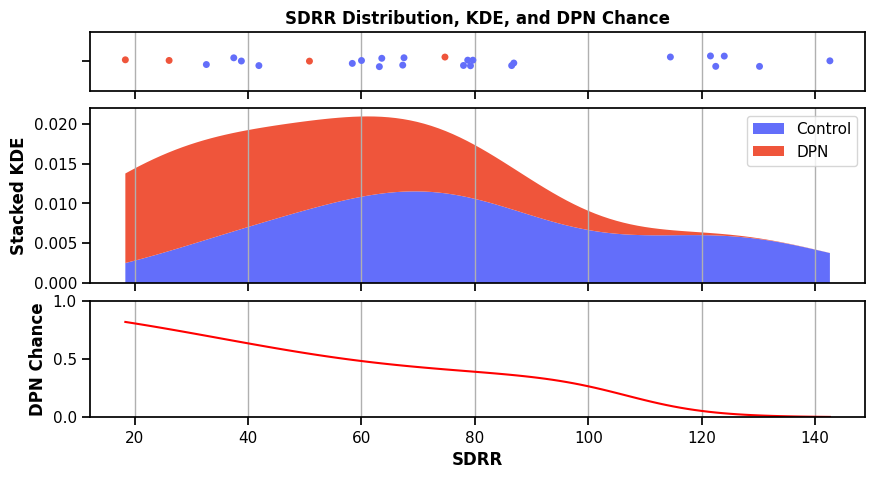

In [21]:
def plot_metric_distribution(metric, kde_df):
   # kde_df = compute_kde_for_metric(median, metric)
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 3, 2], 'hspace': 0.15})
    
    # Upper subplot
    sns.stripplot(data=median, x=metric, hue='DPN', alpha=1, ax=axs[0])
    axs[0].set_title(f'{metric} Distribution, KDE, and DPN Chance')
    axs[0].grid(True, axis='x')
    axs[0].legend().set_visible(False)

    # Middle subplot
    axs[1].stackplot(kde_df['x_values'], kde_df['control_kde'], kde_df['dpn_kde'], labels=['Control', 'DPN'])
    axs[1].legend()
    axs[1].set_ylabel('Stacked KDE')

    # Lower subplot
    sns.lineplot(data=kde_df, x='x_values', y='dpn_chance', color='red', ax=axs[2])
    axs[2].set_xlabel(metric)
    axs[2].set_ylabel('DPN Chance')
    axs[2].set_ylim(0, 1)

    # Remove x labels for the upper and middle plots
    for ax in axs[:2]:
        ax.set_xlabel('')
        ax.set_xticklabels([])

    for ax in axs:
        ax.grid(True, axis='x')

    #plt.tight_layout()
    plt.show()

kde_df = compute_kde_for_metric(median, 'SDRR')
plot_metric_distribution('SDRR', kde_df)

### Drawing all KDEs

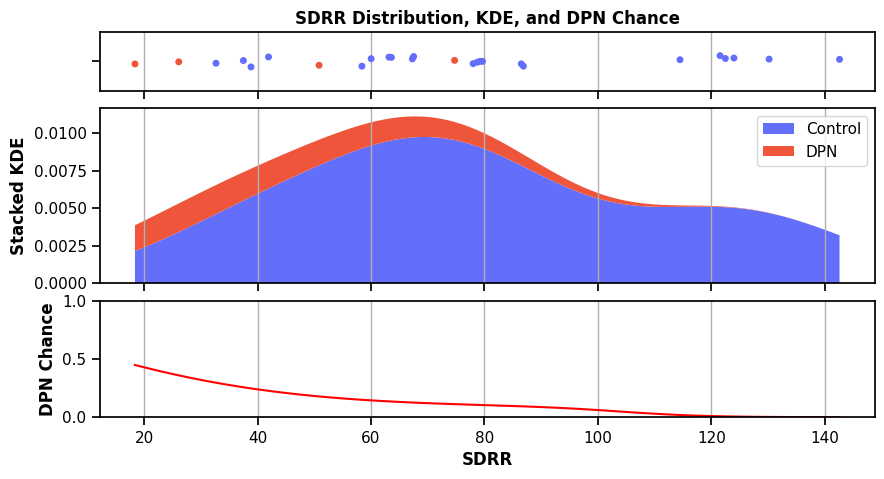

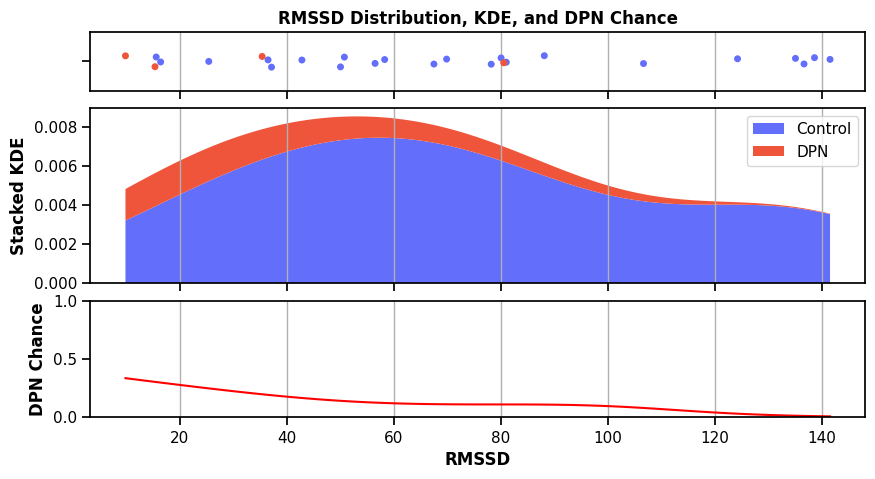

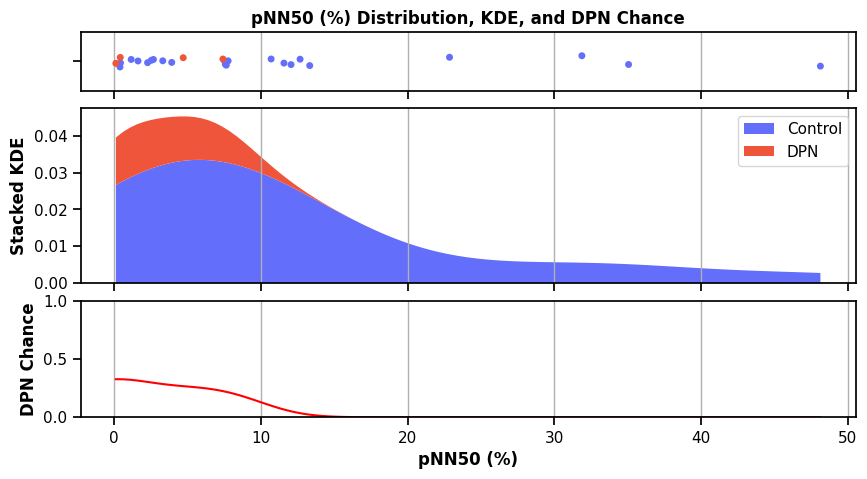

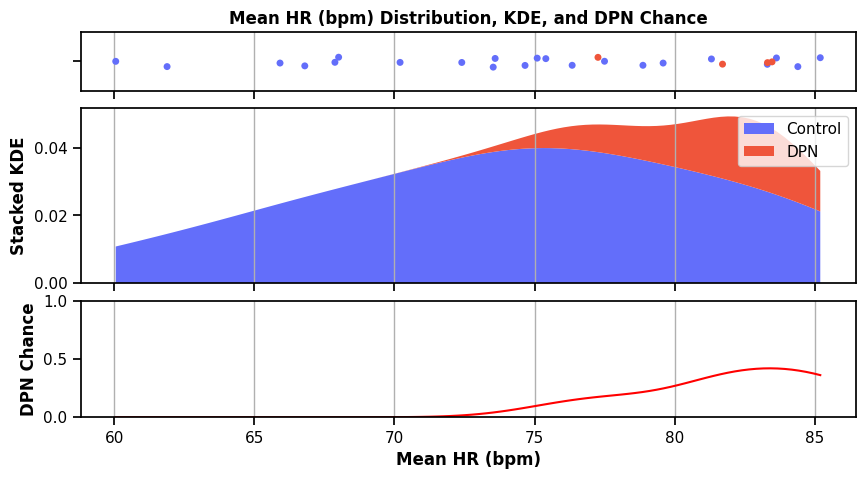

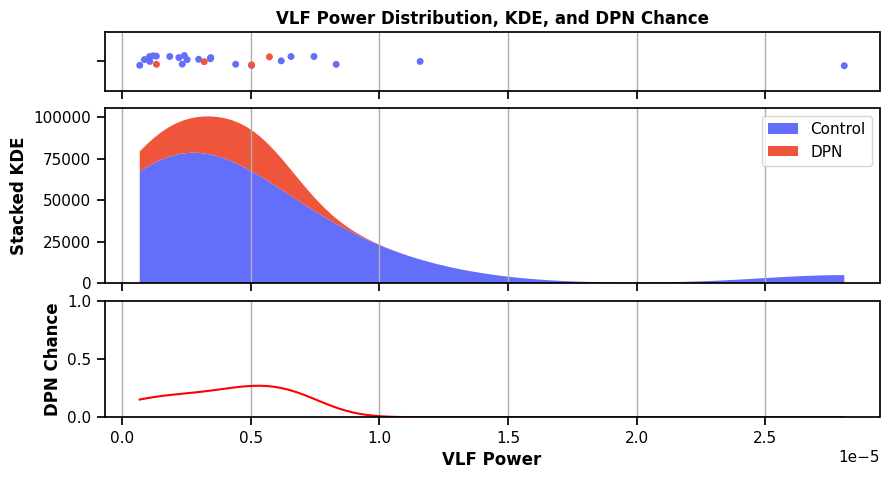

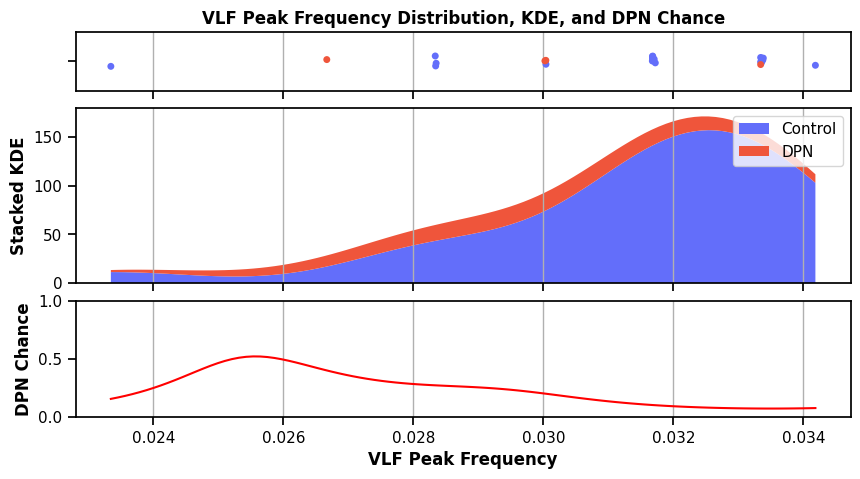

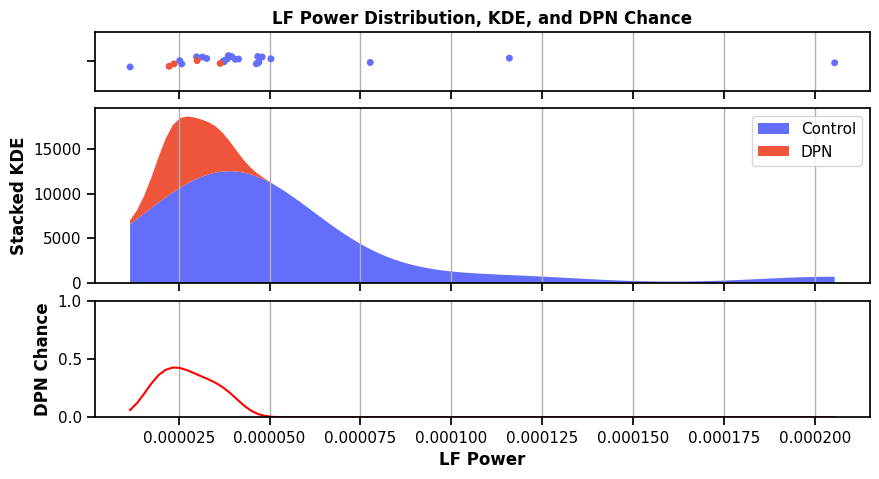

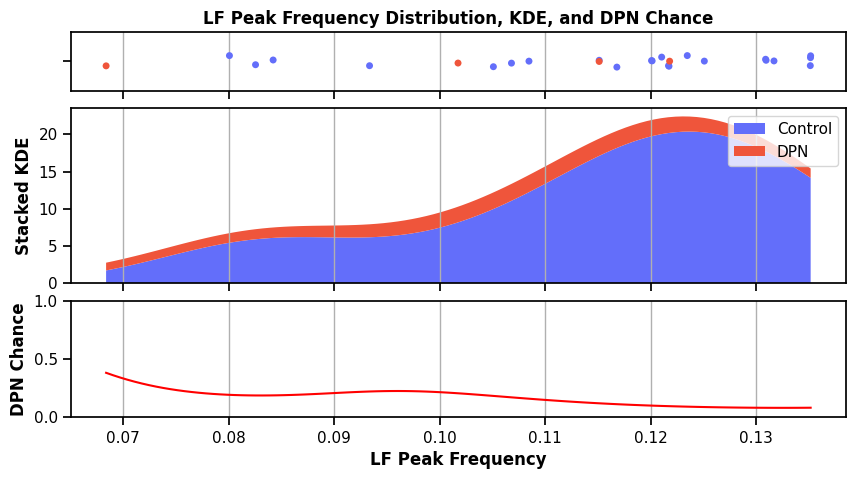

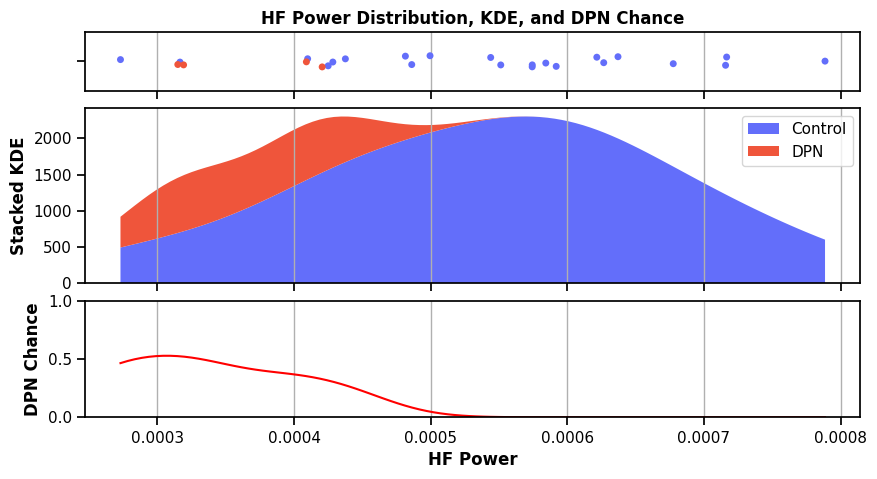

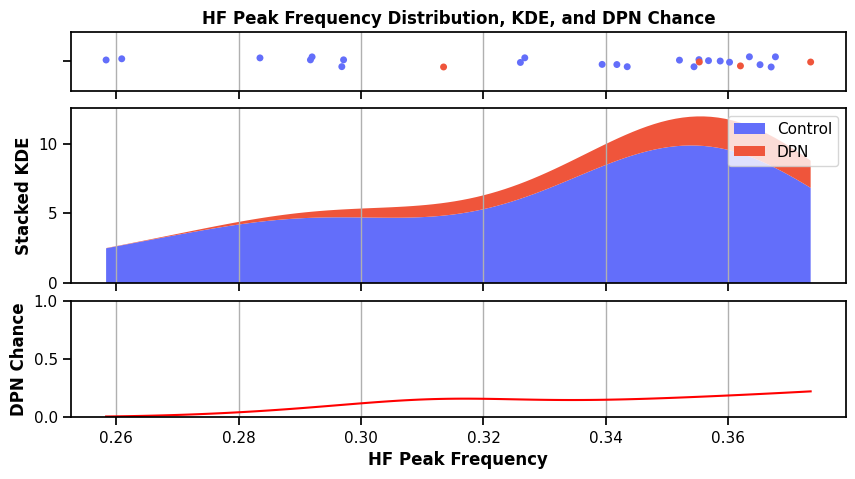

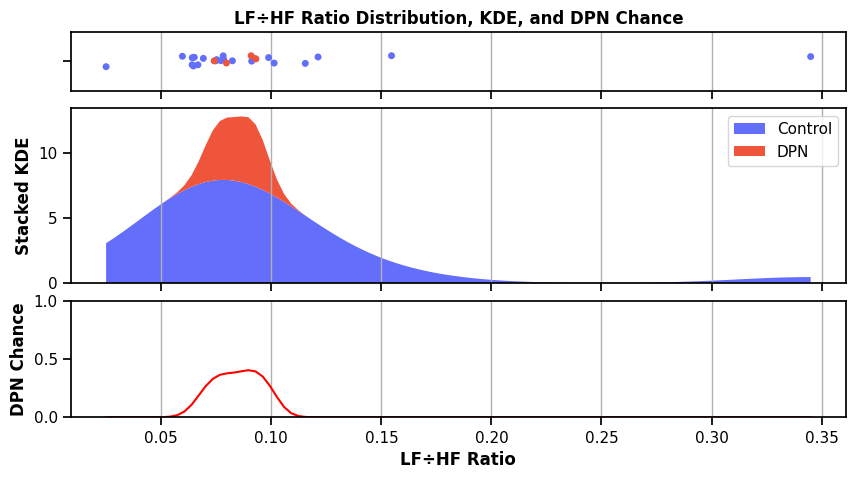

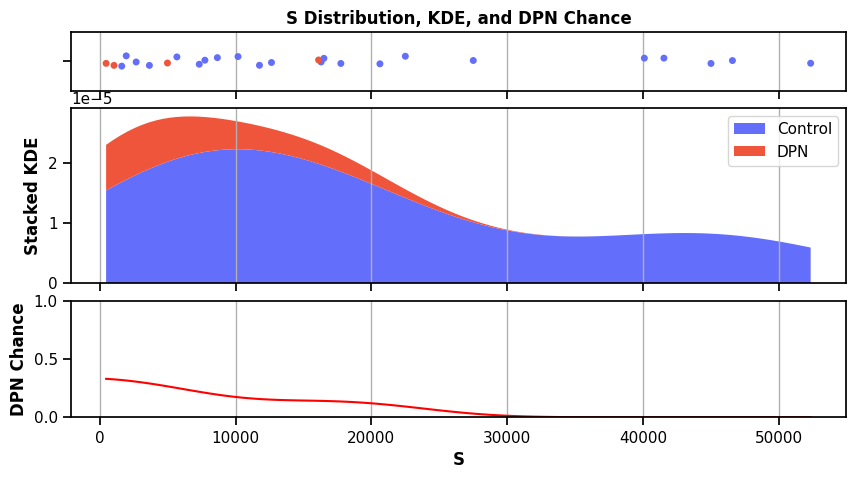

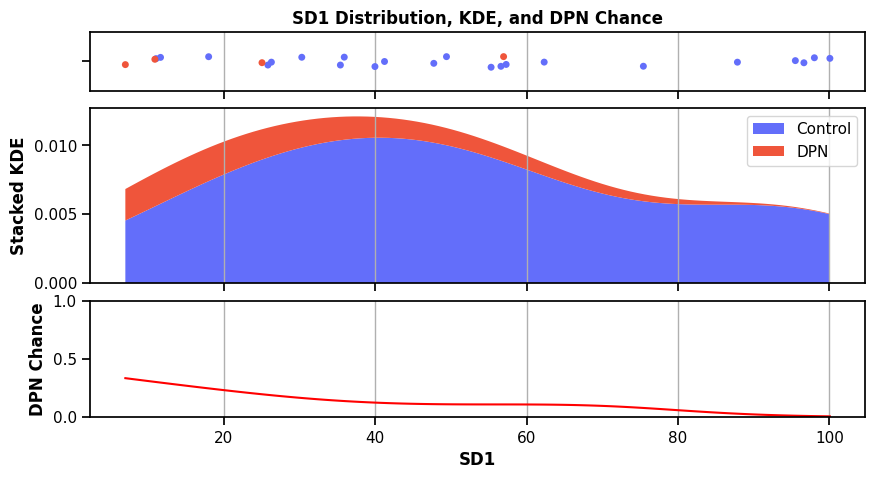

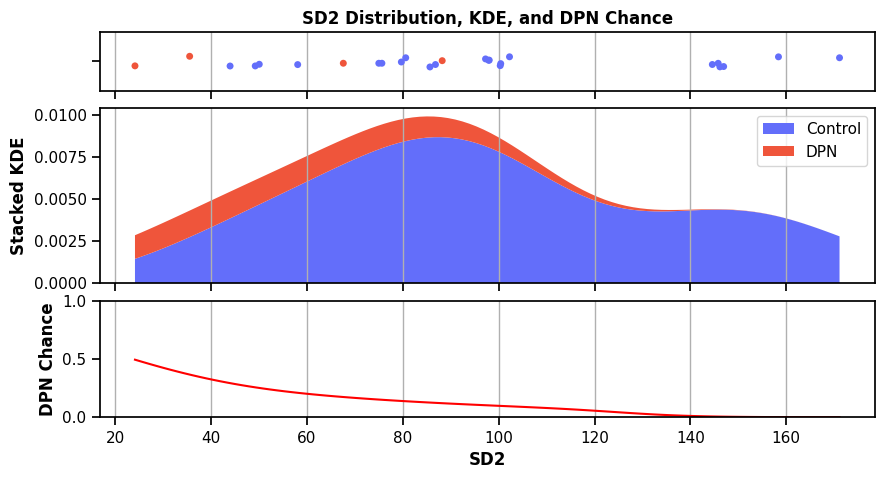

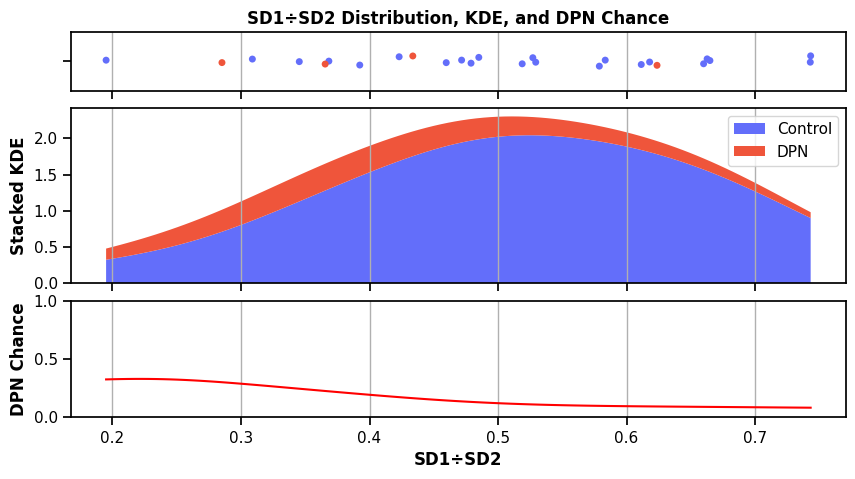

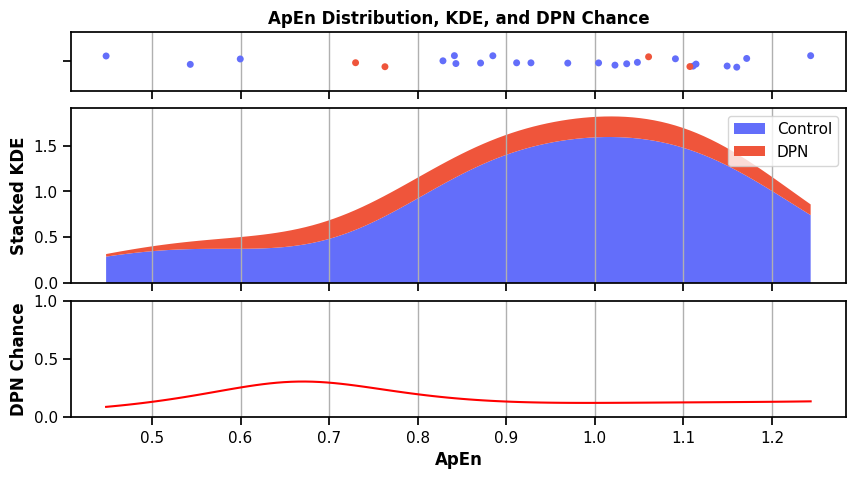

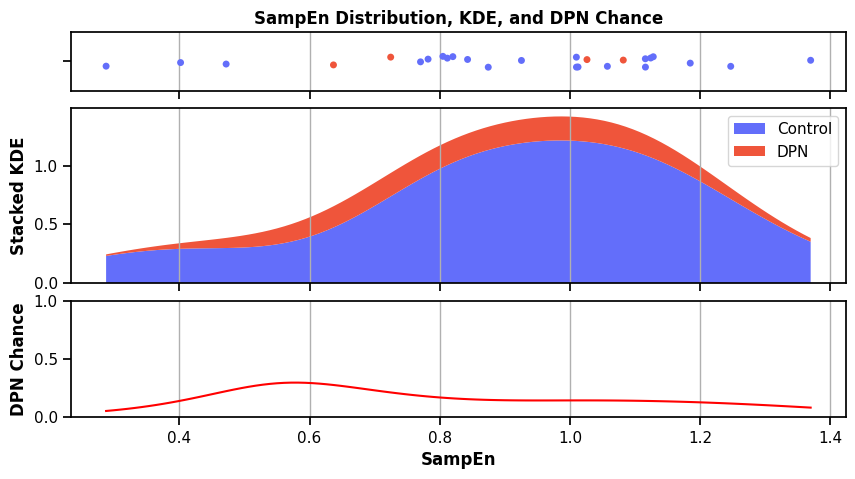

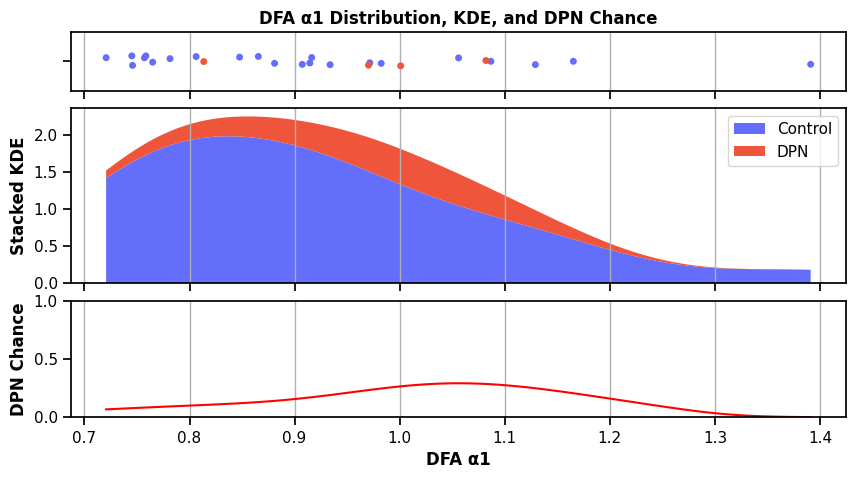

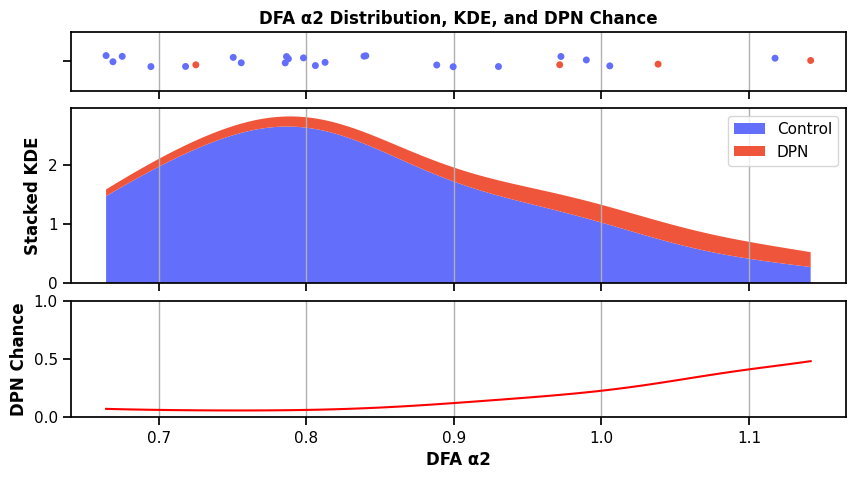

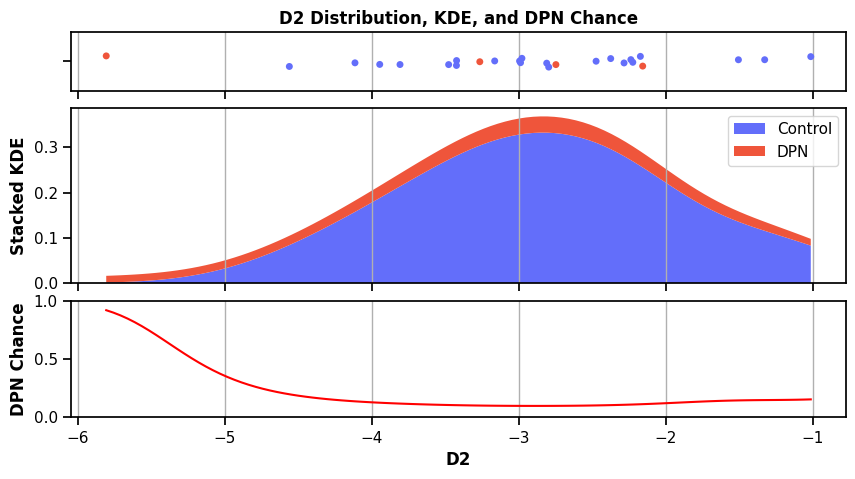

In [ ]:
kde_dict = {metric: compute_kde_for_metric(median, metric, False) for metric in indicator_columns}

for metric, kde_df in kde_dict.items():
    
    plot_metric_distribution(metric, kde_df)
    #break;

In [23]:
chances = deciles.produce_median_melt(data, indicator_columns)
# Create and apply a chance, which is a sample of dpn_chance from kde_dict appropriate metric. Use the closest x_value
def get_closest_dpn_chance(row, kde_dict):
    metric = row['metric']
    value = row['value']
    kde_df = kde_dict[metric]
    closest_index = (kde_df['x_values'] - value).abs().idxmin()
    return kde_df.loc[closest_index, 'dpn_chance']

chances['dpn_chance'] = chances.apply(get_closest_dpn_chance, axis=1, kde_dict=kde_dict)
chances

,id,DPN,metric,value,dpn_chance
0,0,False,SDRR,79.23,0.11
1,3,False,SDRR,63.16,0.13
2,4,False,SDRR,78.74,0.11
3,5,False,SDRR,58.39,0.15
4,7,False,SDRR,67.28,0.13
...,...,...,...,...,...
515,35,False,D2,-1.50,0.14
516,37,True,D2,-5.81,0.92
517,38,True,D2,-2.16,0.11
518,39,True,D2,-3.26,0.10


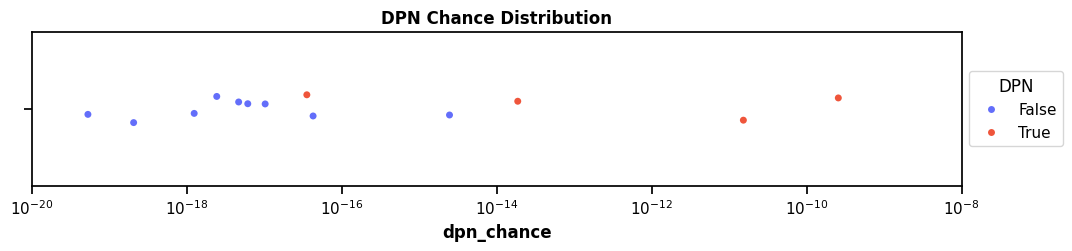

In [24]:
dpn_chance = chances.groupby(['DPN','id'])['dpn_chance'].prod().reset_index()

dpn_chance

plt.figure(figsize=(12, 2))
sns.stripplot(data=dpn_chance, x='dpn_chance', hue='DPN', alpha=1)
plt.xscale('log')

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", title='DPN')
plt.title('DPN Chance Distribution')
plt.xlim([1e-20, 1e-8])
plt.show()

In [25]:

def set_dpn_threshold(cutoff = 1e-6):
    true_positives = ((dpn_chance['dpn_chance'] > cutoff) & (dpn_chance['DPN'] == True)).sum()
    false_positives = ((dpn_chance['dpn_chance'] > cutoff) & (dpn_chance['DPN'] == False)).sum()
    true_negatives = ((dpn_chance['dpn_chance'] <= cutoff) & (dpn_chance['DPN'] == False)).sum()
    false_negatives = ((dpn_chance['dpn_chance'] <= cutoff) & (dpn_chance['DPN'] == True)).sum()
    total_positives = (dpn_chance['DPN'] == True).sum()
    total_negatives = (dpn_chance['DPN'] == False).sum()
    precision = true_positives / (true_positives + false_positives)
    accuracy = (true_positives + true_negatives) / (total_positives + total_negatives)
    recall = true_positives / total_positives
    
    results = {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives,
        'total_positives': total_positives,
        'total_negatives': total_negatives,
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall
    }
    return results



results = set_dpn_threshold()

confusion_matrix = pd.DataFrame({
    'Positive': [results['true_positives'], results['false_positives']],
    'Negative': [results['true_negatives'], results['false_negatives']]
}, index=['True', 'False'])

print("Count of identification instances:")
display(confusion_matrix)

print("Precision: ", results['precision'])
print("Accuracy: ", results['accuracy'])
print("Recall: ", results['recall'])


Count of identification instances:


C:\Users\326po\AppData\Local\Temp\ipykernel_14272\2353307582.py:8: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)


,Positive,Negative
True,0,22
False,0,4


Precision:  nan
Accuracy:  0.8461538461538461
Recall:  0.0


C:\Users\326po\AppData\Local\Temp\ipykernel_14272\601007318.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_results = pd.concat([threshold_results, pd.DataFrame({
C:\Users\326po\AppData\Local\Temp\ipykernel_14272\2353307582.py:8: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)


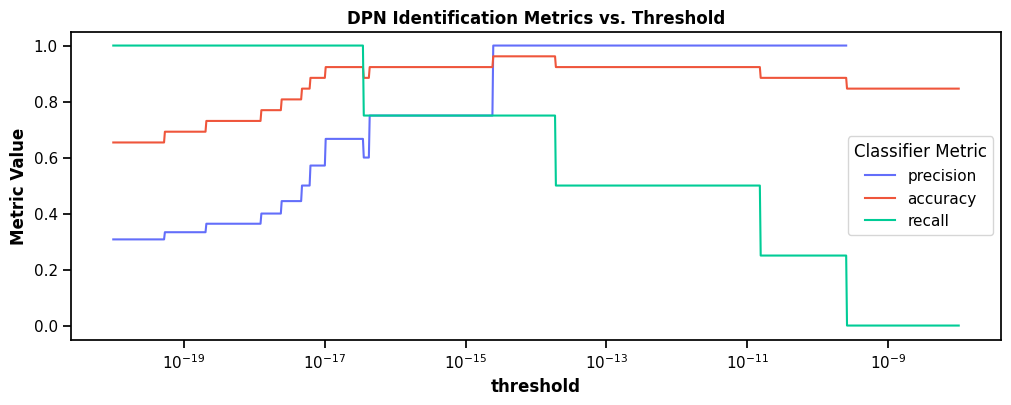

In [26]:
thr_columns = ['threshold', 'precision', 'accuracy', 'recall']
threshold_results = pd.DataFrame(columns=thr_columns)

for threshold in np.logspace(-20, -8, 1000):
    #print(f"Threshold: {threshold}")
    results = set_dpn_threshold(threshold)
    threshold_results = pd.concat([threshold_results, pd.DataFrame({
        'threshold': [threshold],
        'precision': [results['precision']],
        'accuracy': [results['accuracy']],
        'recall': [results['recall']]
    })], ignore_index=True)

plt.figure(figsize=(12, 4))
plt.title('DPN Identification Metrics vs. Threshold')
for metric in thr_columns[1:]:
    sns.lineplot(data=threshold_results, x='threshold', y=metric, label=metric)
plt.legend(title='Classifier Metric')
plt.ylabel('Metric Value')
plt.xscale('log')
plt.show()